In [3]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch
import anndata

In [30]:
adata_rna = sc.read_h5ad("/home/icb/dominik.klein/tmp/GLI3_KO_multiome_18d_srt_rna_processed.h5ad")
adata_activity = sc.read_h5ad("/home/icb/dominik.klein/tmp/GLI3_KO_multiome_18d_srt_activity_processed.h5ad")

In [31]:
adata_rna.layers["counts"] = adata_rna.layers["raw_counts"].copy()
adata_activity.layers["counts"] = adata_activity.layers["raw_activity"].copy()

In [32]:
adata_rna_copy = adata_rna[:, list(set(adata_activity.var_names).intersection(adata_rna.var_names))]
adata = anndata.concat((adata_rna_copy, adata_activity), label="batch")

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [33]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=10000,
    batch_key="batch",
    subset=True,
)

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [34]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

In [35]:
model = scvi.model.SCVI(adata)

In [36]:
model.train(early_stopping=True)

/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=248 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 248/248: 100%|██████████████████████████████████████████████████████████████████████████| 248/248 [11:54<00:00,  2.88s/it, loss=7.31e+03, v_num=1]


In [37]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [38]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata)

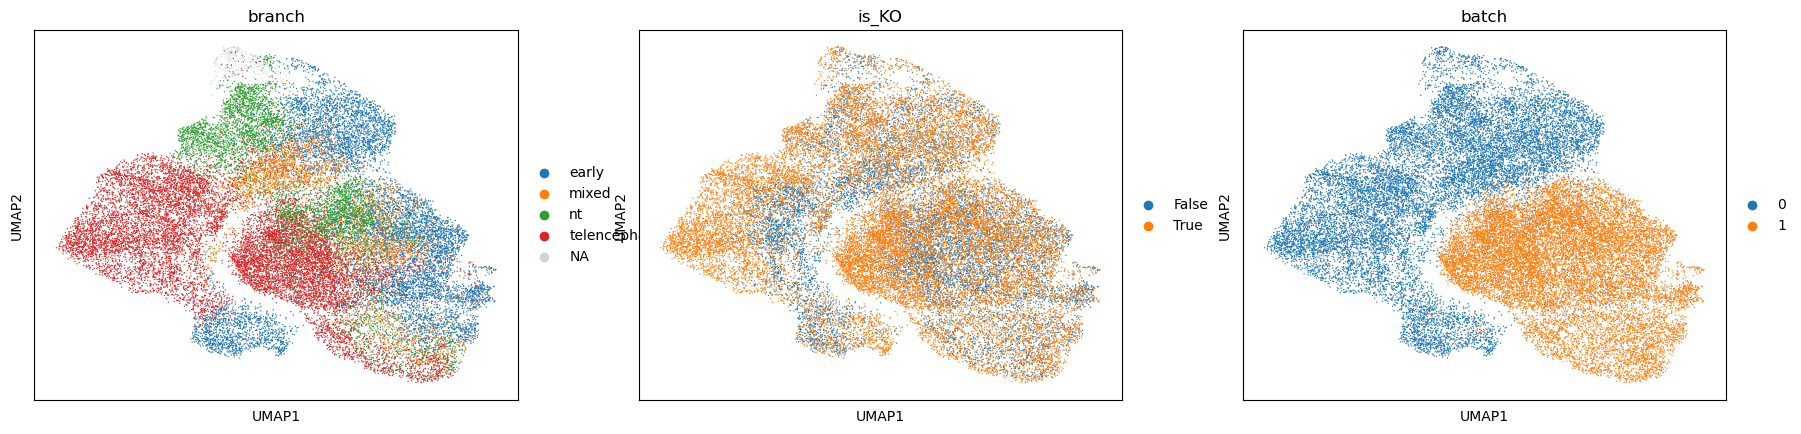

In [39]:
sc.pl.umap(adata, color=["branch", "is_KO", "batch"])

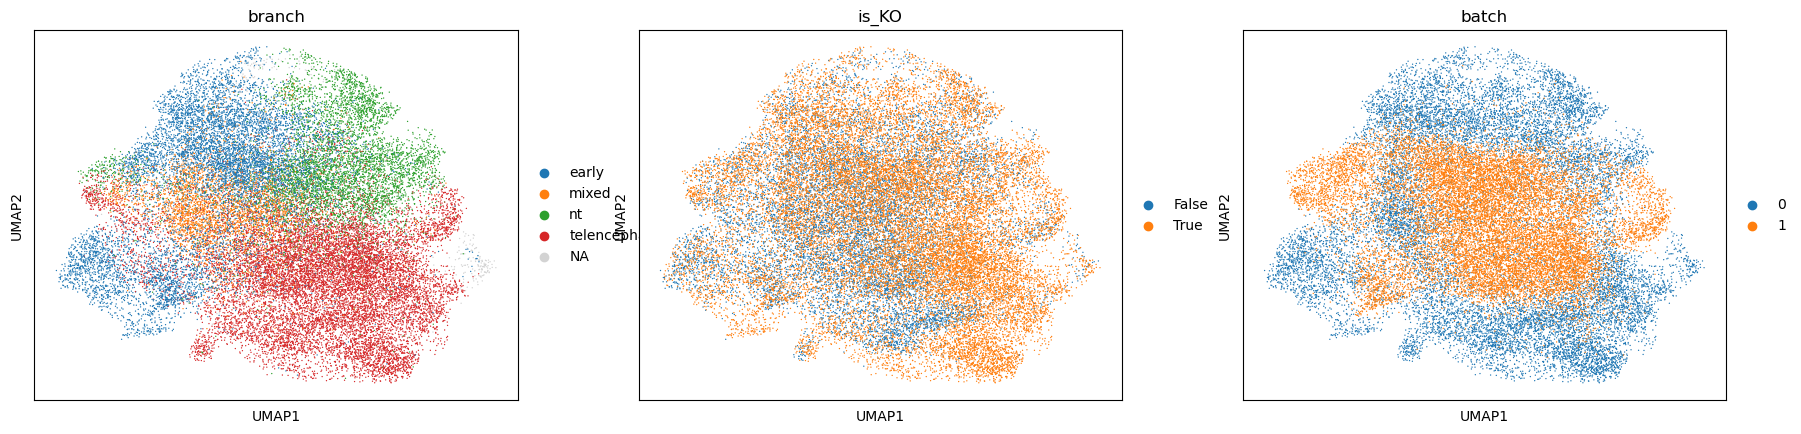

In [19]:
sc.pl.umap(adata, color=["branch", "is_KO", "batch"])

In [21]:
adata.obs["batch"] = adata.obs["batch"].astype("category")

In [24]:
adata.obs["_scvi_batch"] = adata.obs["_scvi_batch"].astype("category")
adata.obs["_scvi_labels"] = adata.obs["_scvi_labels"].astype("category")

In [26]:
del adata.obs

In [27]:
adata.write("/home/icb/dominik.klein/tmp/tmp_integrated.h5ad")

""
GLI3_WT_A4_day19_AAACAGCCACCATATG-1
GLI3_WT_A4_day19_AAACAGCCAGGACCAA-1
GLI3_WT_A4_day19_AAACAGCCAGGTTCAC-1
GLI3_WT_A4_day19_AAACAGCCATAGCGAG-1
GLI3_WT_A4_day19_AAACAGCCATCAGTAT-1


In [ ]:
sc.pl.umap(adata, color="batch", groups=)